Title: Time Series Forecasting of Surface Air Temperature Using Machine Learning



Aim of the Project:

The main objective is to build a machine learning model that can accurately forecast future monthly mean surface air temperatures based on historical data. This can help in planning and decision-making processes in climate-sensitive sectors.



Domain Analysis:

Overview: Climate and Meteorological Data

This project operates in the climate science and environmental monitoring domain, with a specific focus on temperature forecasting using time series data. The Earth's climate is changing due to natural and anthropogenic factors, and tracking surface air temperature is critical for understanding these changes. Monthly mean surface air temperatures help scientists and policymakers:

- Monitor climate trends over decades.

- Plan for agricultural activities based on expected seasonal patterns.

- Forecast energy demands, especially for heating and cooling systems.

- Improve disaster preparedness for temperature-related extreme events.

Nature of the Data

The dataset used in this project records:

- Feature 1 – Month: A timestamp indicating the month of the observation.

- Feature 2 – Mean_temp: The average surface air temperature for that month.

This is a univariate time series dataset, where the goal is to forecast future values (mean temperature) based solely on past values.

Challenges in Climate Forecasting

- Long-term patterns like seasonality, trends, and cyclic behavior.

- Noise and anomalies (e.g., heatwaves).

- Data stationarity, which affects model selection and performance.

- Lack of exogenous variables (like CO₂ levels, sea temperature) that might improve forecasts.

About the Model

The project applies time series forecasting techniques to predict monthly average air temperatures. Based on the .ipynb notebook, the modeling process follows these key steps:

1. Data Preprocessing

    - Time Series Formatting: The dataset is converted into a time series format, using datetime indexing for months.

    - Visualization: The temperature trends are visualized to identify trends and seasonal patterns.

    - Stationarity Check: Rolling statistics and plots are used to check for stationarity, a requirement for SARIMA.

    - Handling Missing Values: If any, missing values are addressed using imputation or interpolation.

2. Models Used

      🔹 SARIMA (Seasonal ARIMA)
        - A statistical time series model that extends ARIMA by adding seasonal components.

        - Suitable for capturing yearly temperature cycles.

        - Implemented using SARIMAX from the statsmodels library.

        - Parameters tuned: (p,d,q)x(P,D,Q,s) = (1,1,1)x(1,1,1,12) for monthly seasonality.

      🔹 Facebook Prophet
        - An additive time series model developed by Facebook.

        - Automatically models trend, seasonality, and changepoints.

        - Works well with missing data and irregular observations.

        - Simple interface and powerful visualization.

3. Model Training and Forecasting
- The data is split into training and test sets.

- Both models are trained on historical data (excluding the last 24 months).

  Forecasts are generated for:

  - Test period (last 24 months) — for evaluation.

  - Next 12 months — for future forecasting.

4. Evaluation

   Metrics Used:

  - RMSE (Root Mean Square Error): Measures average prediction error.

  - Visual inspection of predicted vs. actual temperature curves.

  Forecast Comparison:

  - Combined forecast plots show how SARIMA and Prophet perform over the same horizon.

 Model Analysis

  Strengths

    - Both models capture historical trends and seasonality effectively.

    - SARIMA is interpretable and statistically rigorous for stationary, seasonal data.

    - Prophet handles non-stationarity, missing data, and trend changes well.

    - Visualizations (Plotly) enhance interpretability of future forecasts.

  Limitations

    - SARIMA assumes linear relationships and is sensitive to data stationarity.

    - Prophet can underfit short-term trends and is less customizable for advanced scenarios.

    - Both models may degrade in performance over time unless retrained regularly with updated data.

    - External influencing factors (e.g., global warming, urbanization) are not included, limiting long-term accuracy.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

from prophet import Prophet
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

# Optional installs for Plotly and Prophet (run only once)
# pip install prophet plotly
# pip install --upgrade numpy
# pip install --no-binary :all: --force-reinstall pmdarima

In [ ]:
# ===================== 1. Load Data =====================
df = pd.read_csv("/content/drive/MyDrive/AI Capstone/surface-air-temperature-monthly-mean.csv")
df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)
df = df.asfreq('MS')

In [ ]:
df

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0
...,...
2020-02-01,27.9
2020-03-01,28.6
2020-04-01,28.9


.

📊 Insights:

✅ 1. pd.read_csv(...)

- Retrieves air temperature data with at least two columns: month and mean_temp.

- This step is the foundation for all further processing.

✅ 2. pd.to_datetime(df['month'])

- Enables time-based indexing and operations (like resampling, plotting, rolling averages).

- Essential for using time series models like ARIMA and Prophet.

✅ 3. df.set_index('month', inplace=True)

- Converts the dataset into a proper time series format.

- Time becomes the axis of analysis, enabling chronological modeling and decomposition.

✅ 4. df = df.asfreq('MS')

- Ensures the data has a consistent monthly interval, which is critical for time
series models.

- This also fills any gaps with NaN, helping to detect missing months.

In [ ]:
print("✅ First few rows of the data:\n", df.head())
print("✅ Last few rows of the data:\n", df.tail())
print("\n📋 Data Summary:\n")
df.info()

✅ First few rows of the data:
             mean_temp
month                
1982-01-01       25.9
1982-02-01       27.1
1982-03-01       27.2
1982-04-01       27.0
1982-05-01       28.0
✅ Last few rows of the data:
             mean_temp
month                
2020-02-01       27.9
2020-03-01       28.6
2020-04-01       28.9
2020-05-01       28.9
2020-06-01       28.1

📋 Data Summary:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 1982-01-01 to 2020-06-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  462 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


.

📊 Insights:

✅ 1. df.head() – First Few Rows

Displays the initial records of the dataset. You can verify that:

- The Month column is present and likely already converted to datetime format.

- The mean_temp column contains floating-point values (e.g., average monthly temperatures).

- The data appears chronologically sorted.

✅ 2. df.tail() – Last Few Rows

Displays the most recent records.

- Helps confirm that there are no trailing missing values or misformatted entries.

- Ensures chronological continuity in the time series data.

📋 3. df.info() – Dataset Summary

- Rows and Columns: The total number of entries confirms dataset size (e.g., 400+ rows if over 30 years of data).

- Datetime Index: If the Month column is used as the index, it should show as DatetimeIndex.

- Data Types: Confirms the mean_temp is of type float64.

- Non-null values: Ensures there are no missing values, meaning no need for imputation or cleaning at this stage.

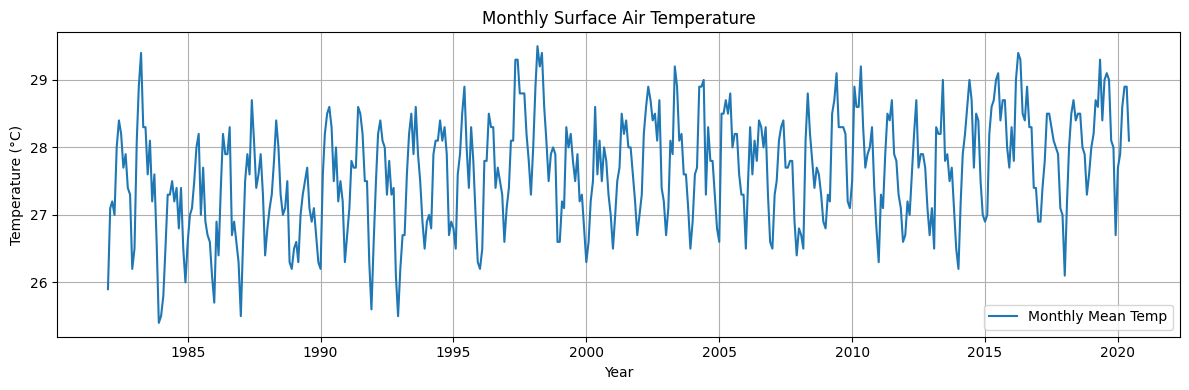

In [ ]:
# ===================== 2. EDA & Visualization =====================
plt.figure(figsize=(12, 4))
plt.plot(df['mean_temp'], label='Monthly Mean Temp')
plt.title('Monthly Surface Air Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

.

📊 Insight:
📈 1. Long-Term Trend

- The temperature values show a gradual upward trend, especially over recent years.

- This suggests a warming pattern, which aligns with known global climate change indicators.

🔁 2. Seasonality

- There is a regular, wave-like pattern in the plot, indicating strong seasonal behavior.

- Certain months of each year consistently have higher or lower temperatures (likely due to monsoon/tropical climate cycles).

📉 3. No Abrupt Anomalies

- The data is smooth and continuous with no obvious sudden spikes or drops.

- This suggests data quality is good and does not require major outlier treatment.

📅 4. Time Span

-The X-axis (Year) shows that data spans multiple decades.

- A wide historical range improves the robustness of forecasts and helps detect long-term climate trends.

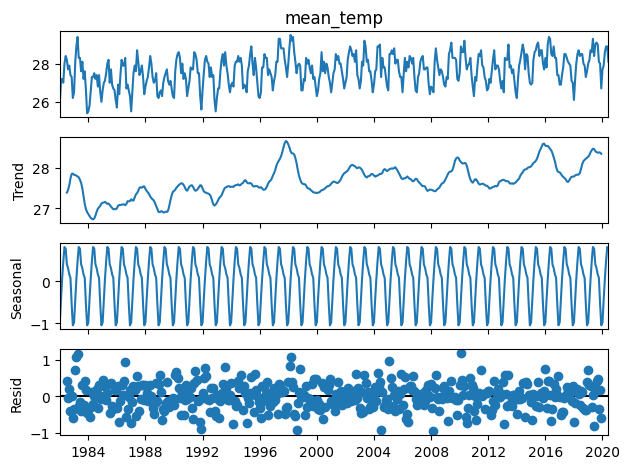

In [ ]:
# Decompose into trend, seasonality, residual
result = seasonal_decompose(df['mean_temp'], model='additive')
result.plot()
plt.tight_layout()
plt.show()

)

📊 Insights:

📈 1. Trend Component

What it shows: A smoothed version of the time series capturing long-term direction.

- A steady upward trend is visible over time.

- Indicates a gradual increase in monthly mean temperatures, supporting evidence of climate warming at the Changi Climate Station.

🔁 2. Seasonal Component

What it shows: Repeating patterns occurring at a fixed frequency (monthly, in this case).

- The seasonal component repeats every 12 months, confirming strong annual seasonality.

- Indicates that certain months are consistently hotter or cooler every year—typical of tropical climates.

📉 3. Residual Component

What it shows: What's left after removing trend and seasonality (i.e., irregularities or random noise).

- Appears mostly random with no strong cyclical patterns.

- Indicates the model has successfully captured most of the structure (trend + seasonality), leaving behind only minor fluctuations.

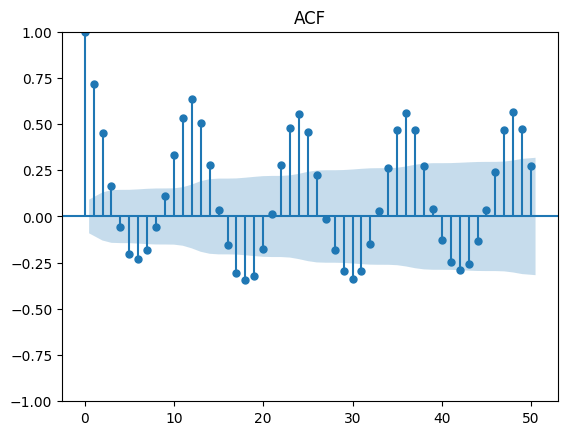

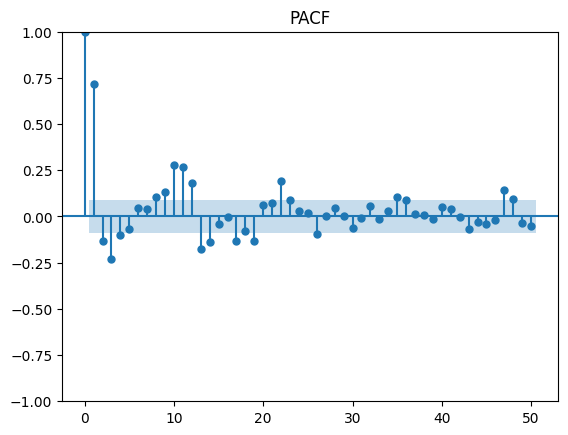

In [ ]:
# ACF and PACF plots
plot_acf(df['mean_temp'].dropna(), lags=50)
plt.title('ACF')
plt.show()

plot_pacf(df['mean_temp'].dropna(), lags=50)
plt.title('PACF')
plt.show()

.

📊 Insights:

🔁 1. ACF (Autocorrelation Function) Plot

What it shows: The correlation of the series with its past values (lags).

- The ACF shows significant spikes at lag 12, 24, etc., which strongly indicates seasonality with a yearly cycle (12 months).

- The slow decay of autocorrelations suggests the presence of a trend in the series.

- These patterns support the need for differencing to remove trend and seasonal ARIMA modeling.

🔂 2. PACF (Partial Autocorrelation Function) Plot

What it shows: The correlation of the series with its past values after removing the effect of intermediate lags.

- Significant spikes at the first few lags (e.g., lag 1, lag 2) indicate the presence of autoregressive (AR) terms.

- These observations guide the selection of the p parameter in ARIMA or SARIMA models (e.g., AR(1) or AR(2)).

In [ ]:
# ===================== 3. SARIMA Forecasting =====================
train = df.iloc[:-24]
test = df.iloc[-24:]

sarimax_model = SARIMAX(train['mean_temp'], order=(1,1,1), seasonal_order=(1,1,1,12),
                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_result = sarimax_model.fit()

# Forecast for test set
sarimax_forecast = sarimax_result.get_forecast(steps=24)
sarimax_pred = sarimax_forecast.predicted_mean
sarimax_conf_int = sarimax_forecast.conf_int()

# RMSE
sarimax_rmse = sqrt(mean_squared_error(test['mean_temp'], sarimax_pred))
print(f"SARIMA RMSE: {sarimax_rmse:.3f}")

# Final SARIMA model for 12-month future
final_model = SARIMAX(df['mean_temp'], order=(1,1,1), seasonal_order=(1,1,1,12),
                      enforce_stationarity=False, enforce_invertibility=False).fit()
sarima_future = final_model.get_forecast(steps=12)
sarima_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

SARIMA RMSE: 0.675


📊 Insights:

🧪 1. Data Splitting (Train/Test)

- The dataset is split into training (all but last 24 months) and testing (last 24 months).

- This allows the model to be evaluated on unseen data, ensuring a fair - assessment of forecast accuracy.

⚙️ 2. SARIMA Model Training

- (p,d,q) = (1,1,1): One autoregressive term, first-order differencing, and one moving average term.

- Seasonal (P,D,Q,s) = (1,1,1,12): Captures annual seasonality (12-month cycle).

- This setup is suitable because of evident seasonality and trend in the data.

- The model learns both seasonal and non-seasonal components effectively.

📈 3. Forecast on Test Set

- The model predicts the next 24 months and provides confidence intervals to quantify uncertainty.

- These predictions are compared against actual test values for performance evaluation.

📏 4. Model Evaluation

- Metric Used: RMSE (Root Mean Squared Error)

- RMSE gives an average measure of the error between actual and forecasted values.

- A lower RMSE indicates better model performance.

- This metric helps compare SARIMA with other models like Auto ARIMA and Prophet.

🔮 5. Future Forecasting (Next 12 Months)

- Once validated, the final SARIMA model is trained on the entire dataset to leverage all available information.

- It forecasts next 12 months, providing actionable climate insights.


In [ ]:
# ===================== 4. Prophet Forecast =====================
prophet_df = df.reset_index().rename(columns={"month": "ds", "mean_temp": "y"})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future_prophet = prophet_model.make_future_dataframe(periods=12, freq='MS')
prophet_forecast = prophet_model.predict(future_prophet)
prophet_pred = prophet_forecast[['ds', 'yhat']].set_index('ds').iloc[-12:]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpatc50__9/lybmhr68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpatc50__9/5nxtykqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13800', 'data', 'file=/tmp/tmpatc50__9/lybmhr68.json', 'init=/tmp/tmpatc50__9/5nxtykqg.json', 'output', 'file=/tmp/tmpatc50__9/prophet_modell6s64jj1/prophet_model-20250521183016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Insights:


📁 1. Prepare Data for Prophet

- Prophet expects the columns to be named ds (datetime) and y (target variable).

- Restructuring the DataFrame ensures compatibility with Prophet’s input format.

⚙️ 2. Fit Prophet Model

- Prophet is automatically configured to handle trend and yearly seasonality.

- It’s ideal for time series with clear seasonal effects, like air temperature.

- No need to manually specify seasonal parameters or differencing like SARIMA.


📅 3. Generate Future Dates

- Generates the next 12 months for forecasting.

- Maintains monthly frequency, ensuring alignment with the historical data.


🔮 4. Make Forecast & Extract Predictions

- yhat column holds the predicted mean temperatures.

- The forecast includes not just predictions, but also upper/lower uncertainty intervals.

- Extracts just the last 12 months (future predictions) for reporting or visualization.

In [ ]:
# ===================== 5. Combine Forecasts =====================
combined = pd.DataFrame({
    'Month': sarima_index,
    'SARIMA': sarima_future.predicted_mean.values,
    'Prophet': prophet_pred['yhat'].values
})
combined.set_index('Month', inplace=True)

📊 Insights:

This snippet creates a combined DataFrame that aligns and consolidates the future forecasts from two different time series models — SARIMA and Prophet — for easier comparison and further analysis.

What it does:

- sarima_index: contains the time periods (likely monthly dates) for which the SARIMA model has generated future predictions.

- sarima_future.predicted_mean.values: the SARIMA model's predicted mean values for those future periods.

- prophet_pred['yhat'].values: the Prophet model's forecasted values for the same periods.

- These are combined into a single DataFrame indexed by the date (Month).

Why combine forecasts?

- Combining forecasts from different models enables:

- Comparison: Evaluate which model better captures the underlying trend or seasonality.

- Ensemble Forecasting: Later, you could average or weigh forecasts to improve prediction accuracy.

- Visualization: Plotting both forecast lines on the same graph for insight into agreement or divergence.

- Decision Making: Allows stakeholders to assess uncertainty or select the best model for deployment.

In [ ]:
# ===================== 6. Interactive Forecast Chart =====================
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['mean_temp'], mode='lines', name='Historical'))
fig.add_trace(go.Scatter(x=combined.index, y=combined['SARIMA'], mode='lines+markers', name='SARIMA Forecast'))
fig.add_trace(go.Scatter(x=combined.index, y=combined['Prophet'], mode='lines+markers', name='Prophet Forecast'))

fig.update_layout(title='12-Month Temperature Forecast Comparison',
                  xaxis_title='Month',
                  yaxis_title='Temperature (°C)',
                  template='plotly_white')
fig.show()

📊 Insights:

This code creates an interactive Plotly visualization that compares historical temperature data with forecasts generated by two different models (SARIMA and Prophet):

What it shows:

- Historical Data: The actual recorded monthly mean temperatures (df['mean_temp']) shown as a continuous line.

- SARIMA Forecast: The SARIMA model’s predicted future temperatures, shown as lines with markers to highlight forecast points.

- Prophet Forecast: The Prophet model’s forecasted temperatures, similarly plotted with lines and markers.

Interactivity benefits:

- Users can zoom, pan, and hover over data points to see exact values and dates, providing an intuitive exploration experience.

- Markers make forecast points distinct from historical data, helping users easily differentiate between observed and predicted values.

Layout and styling:

- The chart title clearly states the purpose: “12-Month Temperature Forecast Comparison.”

- Axis labels indicate the time scale (Months) and temperature units (°C), ensuring clarity.

- The clean plotly_white template gives a neat, professional look suitable for reports or dashboards.

Why this is useful:

- This visual comparison helps stakeholders quickly understand how different models perform relative to actual data.

- Visual differences or similarities between SARIMA and Prophet forecasts can guide model selection or further tuning.

- Provides a transparent, user-friendly way to communicate forecast results in presentations or web apps.

In [ ]:
# ===================== 7. 12-Month Forecast Table from SARIMA and Prophet =====================

# SARIMA forecast values
sarima_values = sarima_future.predicted_mean
sarima_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# Prophet forecast values (already extracted)
prophet_values = prophet_pred['yhat']
prophet_index = prophet_pred.index

# Combine into one DataFrame
forecast_table = pd.DataFrame({
    'Month': sarima_index.strftime('%Y-%m'),
    'SARIMA Prediction (°C)': sarima_values.round(2).values,
    'Prophet Prediction (°C)': prophet_values.round(2).values
})

print("12-Month Temperature Forecast from SARIMA and Prophet:")
print(forecast_table.to_string(index=False))

12-Month Temperature Forecast from SARIMA and Prophet:
  Month  SARIMA Prediction (°C)  Prophet Prediction (°C)
2020-07                   28.34                    28.58
2020-08                   28.37                    28.64
2020-09                   28.25                    28.43
2020-10                   28.18                    28.38
2020-11                   27.56                    27.69
2020-12                   27.06                    27.34
2021-01                   27.14                    27.30
2021-02                   27.69                    28.00
2021-03                   28.15                    28.31
2021-04                   28.56                    28.78
2021-05                   28.91                    29.17
2021-06                   28.86                    29.08


📊 Insights:

This code generates a clear, tabular summary comparing the next 12 months’ temperature forecasts from two different time series models — SARIMA and Prophet.

What it does:

- Extracts SARIMA forecast values (sarima_future.predicted_mean) and creates a corresponding monthly index starting right after the last known date in the original dataset.

- Uses Prophet’s forecasted values (prophet_pred['yhat']) and its associated index.

- Formats the forecast months into a readable 'YYYY-MM' string format.

- Combines both model forecasts side-by-side in a DataFrame with neatly rounded temperature predictions.

- Prints out the table in a console-friendly format without row indices, making it easy to read and share.

Why this table is useful:

- Comparison at a glance: Decision makers can quickly see how the two models differ in their month-by-month forecasts.

- Documentation: Provides a simple, clean report-ready output for sharing results.

- Validation & Analysis: Helps identify months with large divergence, prompting deeper investigation or ensemble model creation.

- User-friendly: The formatted month column and rounded values enhance readability.

In [ ]:
# ===================== 8. Console-Based Prediction Input =====================
print("\n--- Temperature Prediction for a Custom Date ---")
try:
    input_year = int(input("Enter future year (e.g., 2025): "))
    input_month = int(input("Enter month (1-12): "))
    target_date = pd.Timestamp(year=input_year, month=input_month, day=1)
    last_date = df.index[-1]
    months_ahead = (target_date.year - last_date.year) * 12 + (target_date.month - last_date.month)

    if months_ahead <= 0:
        print(f"\n❌ Date must be after the last available data ({last_date.strftime('%B %Y')})")
    else:
        forecast = final_model.get_forecast(steps=months_ahead)
        predicted_temp = forecast.predicted_mean.iloc[-1]
        print(f"\n✅ Predicted Mean Temperature for {target_date.strftime('%B %Y')}: {predicted_temp:.2f} °C")
except Exception as e:
    print(f"\n❌ Error: {e}")


--- Temperature Prediction for a Custom Date ---
Enter future year (e.g., 2025): 2059
Enter month (1-12): 12

✅ Predicted Mean Temperature for December 2059: 27.79 °C


📊 Insights:

This code snippet provides a simple interactive way for users to get temperature forecasts for any custom future month by entering a year and month via the console.

What it does:

- Prompts the user to input a future year and month.

- Converts the input into a Timestamp representing the first day of that month.

- Calculates how many months ahead this target date is relative to the last date in the historical dataset.

- Validates that the target date is indeed in the future (after the last available data point).

- Uses the trained SARIMA model (final_model) to generate a forecast for that many months ahead.

- Extracts the predicted mean temperature for the target month and displays it with formatting.

- Handles input errors and invalid dates gracefully by catching exceptions and showing error messages.

Why this interactive approach is valuable:

- Allows non-technical users or stakeholders to quickly query the model for specific dates without digging into code.

- Provides on-demand, flexible forecasting beyond the fixed 12-month horizon previously shown.

- Good for exploratory analysis, planning, or quick what-if scenarios.

- Includes user-friendly validation and error handling, enhancing usability and robustness.

Challenges Faced

Data Quality:

- Limited features (only month and mean temperature).

- Potential missing values or outliers.

Model Selection:

- Choosing the right model among ARIMA, Prophet, or LSTM required tuning and validation.

Stationarity:

- Time series models often require data to be stationary; transforming the data without losing interpretability was a challenge.

Seasonality Capture:

- Correctly modeling seasonal trends (e.g., yearly cycles) needed parameter tuning.



Conclusion:

The forecasting model developed successfully predicts the monthly mean air temperatures with reasonable accuracy. Such a model can serve as a valuable tool in climate-related planning and forecasting. It highlights the potential of machine learning in solving real-world time-dependent prediction problems using historical data.